## Introduction

This machine learning model is to design a scoring algorithm that will determine the loan approval based in the probability of whether the borrower will default. 

## Imports

Import all the necessary libraries and functions for the model.

In [52]:
# Import Python libraries for data manipuation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics 


# Perform feature selection using a variance threshold
from sklearn.feature_selection import VarianceThreshold


# Import the Python machine learning libraries we need
from sklearn import preprocessing 
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import r2_score


# Import some convenience function
from functions import *

## Read in Data

The data is already given. The following files will be used.
The train variable ("application_train.csv" file) will return a dataframe to be used for training and testing of the model.

In [53]:
train = pd.read_csv('Desktop/home-credit-default-risk/application_train.csv')

## Visualize Data

In [54]:
target = train['TARGET']
print('Train data shape: ', train.shape)

Train data shape:  (307511, 122)


The training data has 307511 rows (each one a separate loan) and 122 columns (features/variables) including the __TARGET__ (the feature we want to predict).

In [55]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


Some statistical data.

## Clean Data

### Correlation

The correlation coefficient describes the strength and direction of the relationship.

#### Calculate correlation with TARGET variable

In [57]:
corr = train.corr()['TARGET'].sort_values()
print('Most negative correlations:\n', corr.head(10))
print('\nMost positive correlations:\n', corr.tail(10))

Most negative correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64

Most positive correlations:
 FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


### Column types

#### Sorted variables into alphabetical order

In [58]:
sorted(train)

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'CODE_GENDER',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'EMERGENCYSTATE_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT

#### Organize into categorial and numerial variables

In [59]:
recurring_cat_cols = [col for col in train.columns if col[:4] in ['NAME', 'FLAG', 'REG_', 'LIVE']]
cat_cols = ['CODE_GENDER', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
            'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 
            'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
            'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'] + recurring_cat_cols

num_cols = [col for col in train.columns if col not in cat_cols + ['SK_ID_CURR', 'TARGET']]

# Features that don't seem too important:
drop_cols = ['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'WALLSMATERIAL_MODE']
print('Number of categorical features:', len(cat_cols))
print('Number of numerical features:', len(num_cols))

Number of categorical features: 56
Number of numerical features: 64


#### Create label encoder for categorial variables
Machine learning cannot work directly with categorial data.

In [60]:
le = LabelEncoder()
le_count = 0

#Iterate thorugh the columns
for col in train[cat_cols]: 
    le.fit(train[col])                   # train on the training data
    train[col]=le.transform(train[col])  #transform both training and testing data
    le_count += 1                        #keep track of how many columns were label encode
print('%d columns were label encoded.' % le_count)

56 columns were label encoded.


### Remove low variance features
Low variance variables have less impact on the target variable.

#### Caculate variance

In [61]:
var = train.var().sort_values()
print('Low Variance:\n', var.head(80))

Low Variance:
 FLAG_MOBIL                  0.000003
FLAG_DOCUMENT_12            0.000007
FLAG_DOCUMENT_10            0.000023
FLAG_DOCUMENT_2             0.000042
FLAG_DOCUMENT_4             0.000081
                              ...   
DEF_60_CNT_SOCIAL_CIRCLE    0.131255
LIVE_CITY_NOT_WORK_CITY     0.147315
FLAG_EMP_PHONE              0.147671
FLAG_WORK_PHONE             0.159621
REG_CITY_NOT_WORK_CITY      0.177345
Length: 80, dtype: float64


#### Variance featured to be removed

In [62]:
sel = VarianceThreshold(threshold=(0.01))
sel.fit(train)

selected_features = list(train.columns[sel.get_support()])
print("Feature selection", sel.get_support())
print("Selected features:", selected_features)
print("Removed features:", list(train.columns[~sel.get_support()]))

Feature selection [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True False  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False  True
 False  True  True  True  True False False  True False False  True False
 False  True False  True  True  True  True False False  True False False
  True False False  True False  True  True  True  True False False  True
 False False  True  True  True  True  True  True  True  True  True  True
 False  True False  True  True False  True False False False False False
 False False False False False False False False  True  True  True  True
  True  True]
Selected features: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',

#### Remove low variance features

In [63]:
# Transform (remove low variance features)
train_ = sel.transform(train)
# Turn back into a dataframe
train = pd.DataFrame(train_, columns=selected_features)
# Confirm the new shape
train.shape

(307511, 82)

### Check missing values
Machine learning algorithms won't be able to process nulls

In [64]:
missing_values_table(train)

Your selected dataframe has 82 columns.
There are 34 columns that have missing values.


,Missing Values,% of Total Values
FLOORSMIN_MEDI,208642,67.8
FLOORSMIN_AVG,208642,67.8
FLOORSMIN_MODE,208642,67.8
YEARS_BUILD_MODE,204488,66.5
YEARS_BUILD_AVG,204488,66.5
YEARS_BUILD_MEDI,204488,66.5
OWN_CAR_AGE,202929,66.0
EXT_SOURCE_1,173378,56.4
ELEVATORS_MODE,163891,53.3
ELEVATORS_MEDI,163891,53.3


## Exploratory Analysis

### Histogram of numerial variables

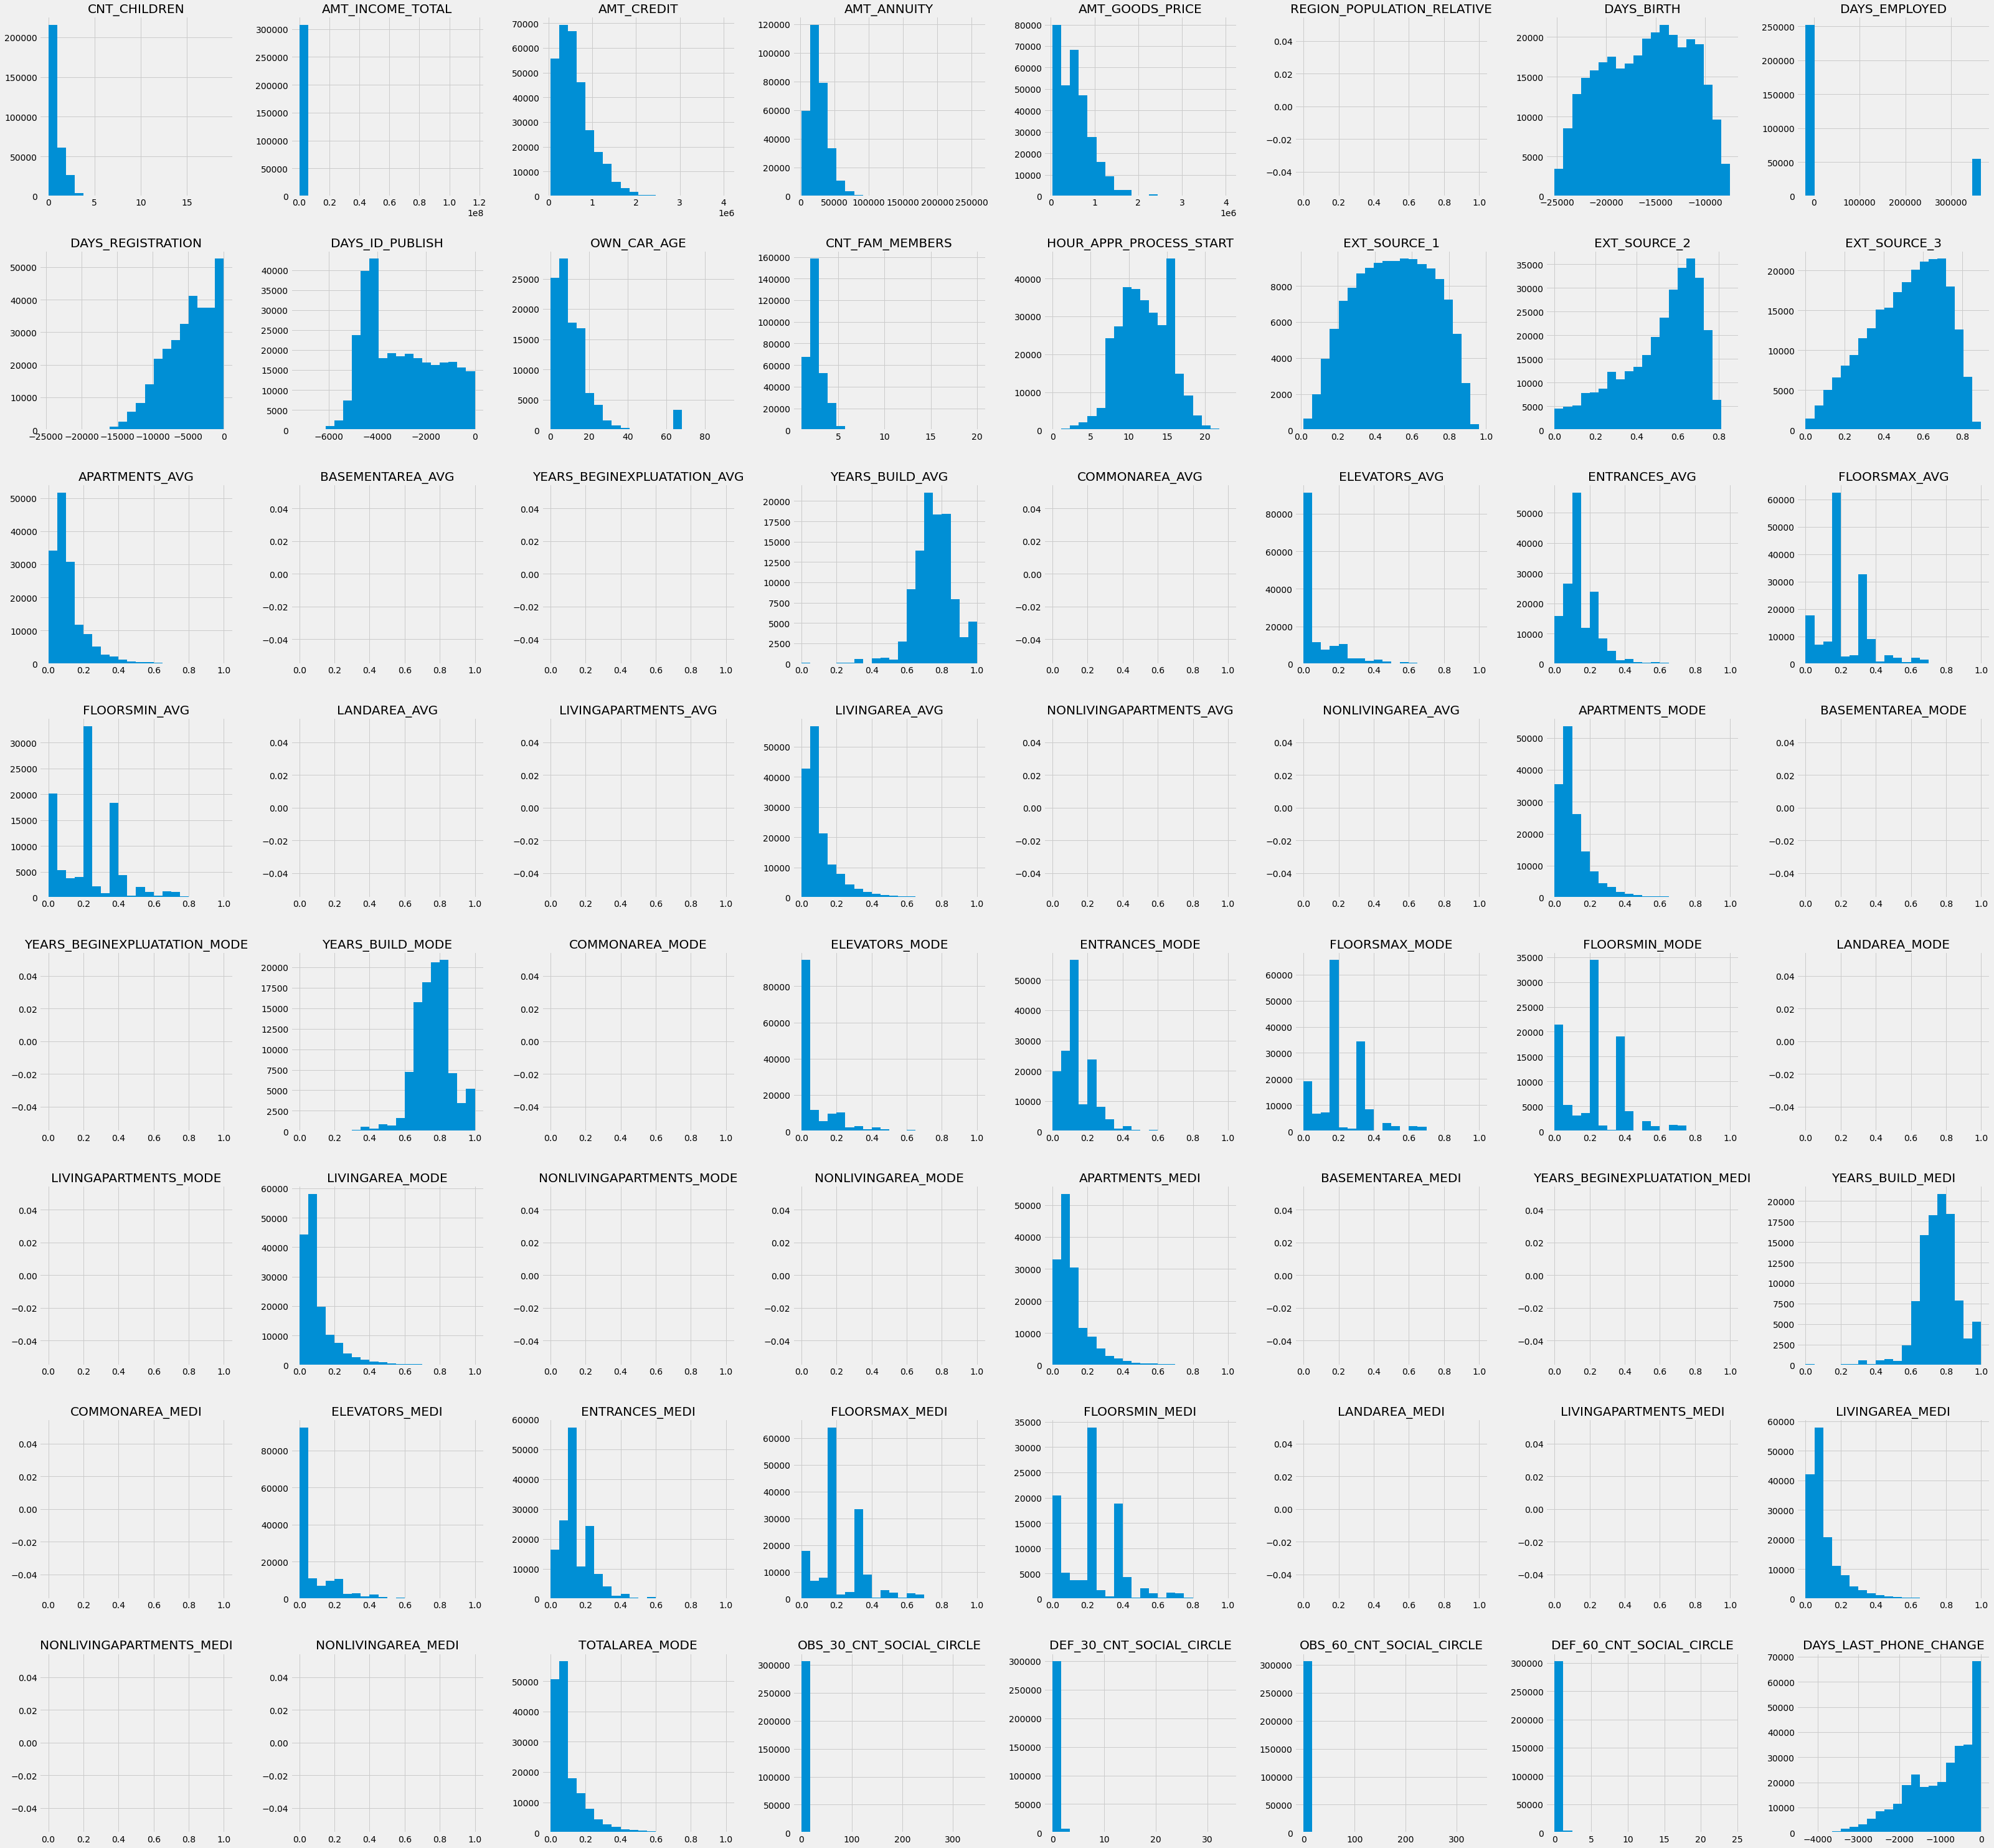

In [65]:
num_train = train.reindex(columns = num_cols)
num_train[num_cols].hist(bins=20, figsize=(50, 50))
plt.show()

__DAYS_EMPLOYED__ column seems contain outliers. <br>
__DAYS_BIRTH, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3__ have the bell curves and the highest correlations between TARGET variable.<br>
__AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE__ are right skewed.

### Distribution of the TARGET column

In [66]:
train['TARGET'].value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='Frequency'>

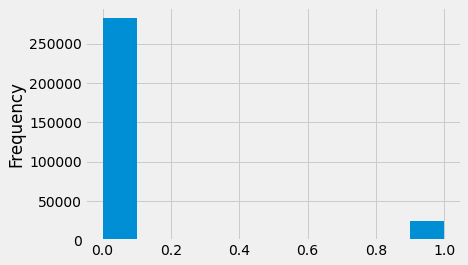

In [67]:
train['TARGET'].astype(int).plot.hist()

The data is highly imbalanced.

#### Explore DAYS_BIRTH

In [68]:
train['DAYS_BIRTH']

0         -9461.0
1        -16765.0
2        -19046.0
3        -19005.0
4        -19932.0
           ...   
307506    -9327.0
307507   -20775.0
307508   -14966.0
307509   -11961.0
307510   -16856.0
Name: DAYS_BIRTH, Length: 307511, dtype: float64

#### Change DAYS_BIRTH (AGE) to positive values

In [69]:
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
train['DAYS_BIRTH'].corr(train['TARGET'])

-0.07823930830982694

#### Plot distribution of AGE

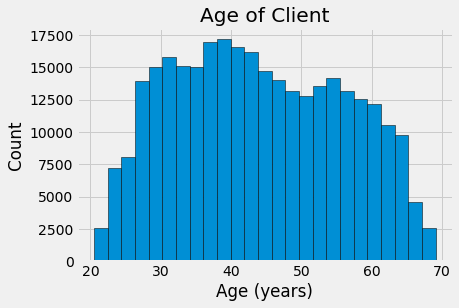

In [70]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

#### Plot density of TARGET vs AGE

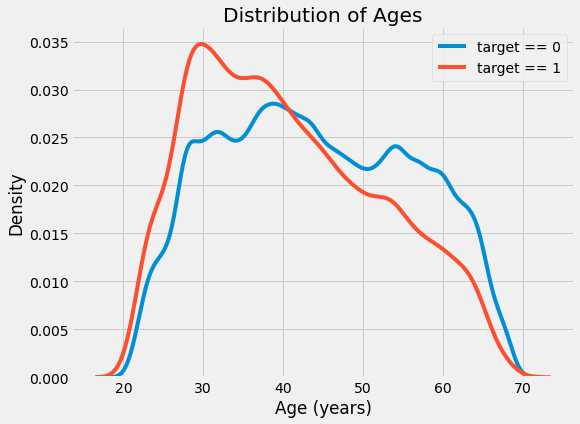

In [71]:
plt.figure(figsize = (8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

 # KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');
plt.legend();

#### Average failure to repay loans by AGE bracket

In [72]:
# Age information into a separate dataframe
age_data = train[['TARGET', 'DAYS_BIRTH']].copy(deep=True)
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
train['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1.0,9461.0,25.920548,"(25.0, 30.0]"
1,0.0,16765.0,45.931507,"(45.0, 50.0]"
2,0.0,19046.0,52.180822,"(50.0, 55.0]"
3,0.0,19005.0,52.068493,"(50.0, 55.0]"
4,0.0,19932.0,54.608219,"(50.0, 55.0]"
5,0.0,16941.0,46.413699,"(45.0, 50.0]"
6,0.0,13778.0,37.747945,"(35.0, 40.0]"
7,0.0,18850.0,51.643836,"(50.0, 55.0]"
8,0.0,20099.0,55.065753,"(55.0, 60.0]"
9,0.0,14469.0,39.641096,"(35.0, 40.0]"


#### Group by the bin and calculate averages

In [73]:
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


#### Plot the AGE bins and TARGET averages

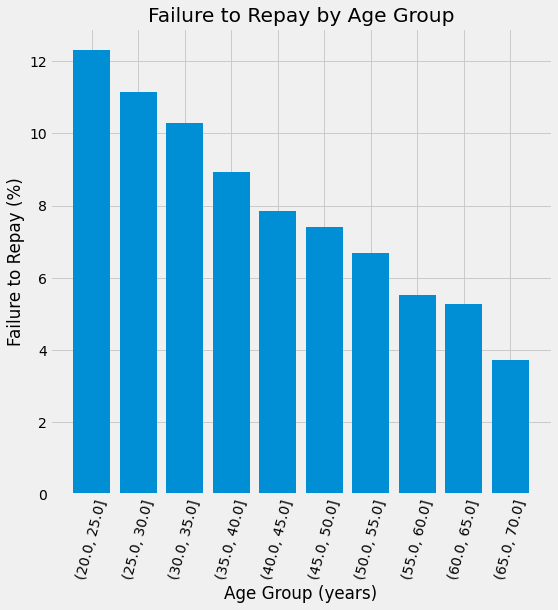

In [74]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

### Exterior sources
The 4 variables with the strongest negative correlations with the __TARGET__ are __EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, and DAYS_BIRTH__. 

#### Correlations

In [75]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


#### Heat map

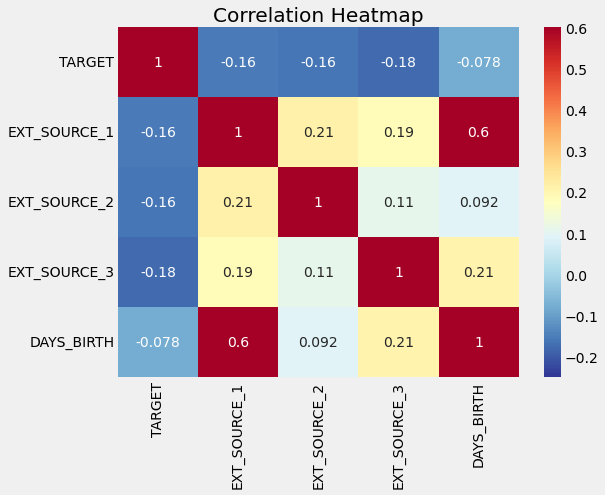

In [76]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three __EXT_SOURCE__ features show negative correlations with the __TARGET__, indicating that as the value of the __EXT_SOURCE__ increases, the client is more likely to repay the loan. We can also see that __DAYS_BIRTH__ has a high positive correltation with __EXT_SOURCE_1__ indicating that maybe one of the factors in this score is the client age.

#### Distribution

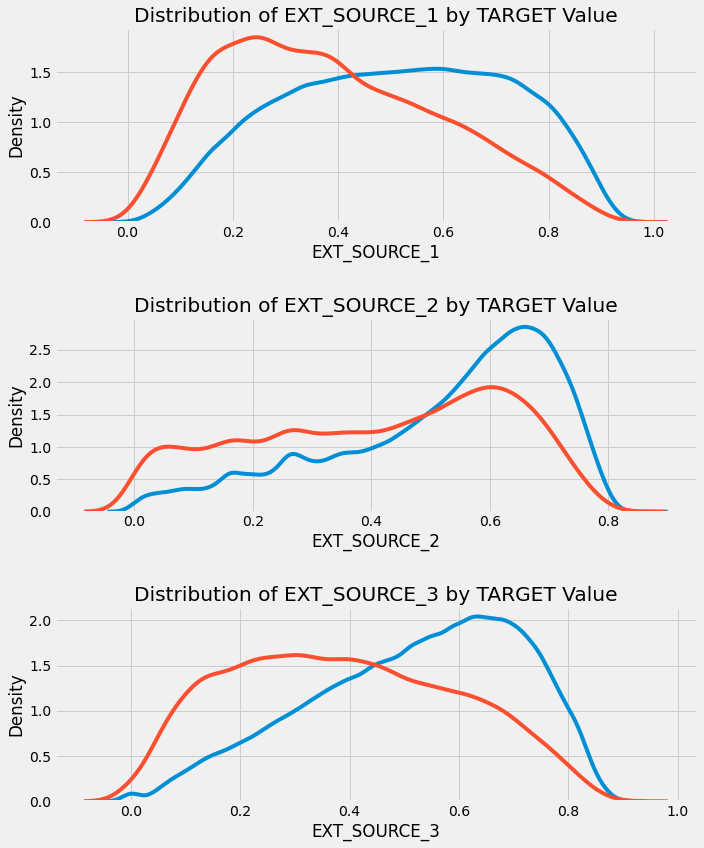

In [77]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by TARGET Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)


## Feature Engineering

### Polynomial features
Polynomial features transform input variables to a power that can help expose important interaction terms, or relationship between input variables and target variable.

#### Create polynomial features

In [78]:
# Make a new dataframe for polynomial features
poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BIRTH', 'TARGET']]

# imputer for handling missing values
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 2)

#### Train and transform

In [79]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 15)


In [80]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 YEARS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 YEARS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 YEARS_BIRTH', 'YEARS_BIRTH^2'], dtype=object)

#### Correlations

In [81]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'YEARS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3   -0.193939
EXT_SOURCE_1 EXT_SOURCE_2   -0.166625
EXT_SOURCE_1 EXT_SOURCE_3   -0.164065
EXT_SOURCE_2                -0.160295
EXT_SOURCE_2 YEARS_BIRTH    -0.156873
EXT_SOURCE_3                -0.155892
EXT_SOURCE_3 YEARS_BIRTH    -0.150109
EXT_SOURCE_2^2              -0.149512
EXT_SOURCE_3^2              -0.141662
EXT_SOURCE_1 YEARS_BIRTH    -0.104882
Name: TARGET, dtype: float64
EXT_SOURCE_1^2   -0.091034
YEARS_BIRTH      -0.078239
YEARS_BIRTH^2    -0.076672
TARGET            1.000000
1                      NaN
Name: TARGET, dtype: float64


#### Merge back into the trainning dataframe

In [82]:
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = train['SK_ID_CURR']
app_train_poly = train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
train = app_train_poly
train['TARGET'] = target

Training data with polynomial features shape:  (307511, 99)


### Outliers

In [83]:
train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

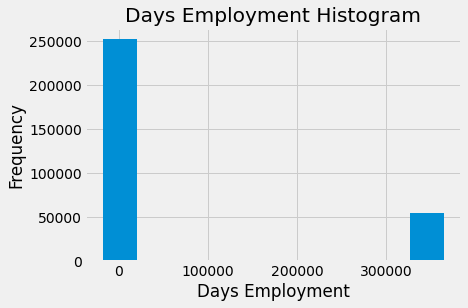

In [84]:
train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

There are anomalous values, which are __365243__, in the __DAYS_EMPLOYED__ column.

#### Replace anomalous values/outliers

In [85]:
train['DAYS_EMPLOYED'] = abs(train['DAYS_EMPLOYED'])
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
train['DAYS_EMPLOYED'].fillna(train['DAYS_EMPLOYED'].median(), inplace=True)

#### Distribution 

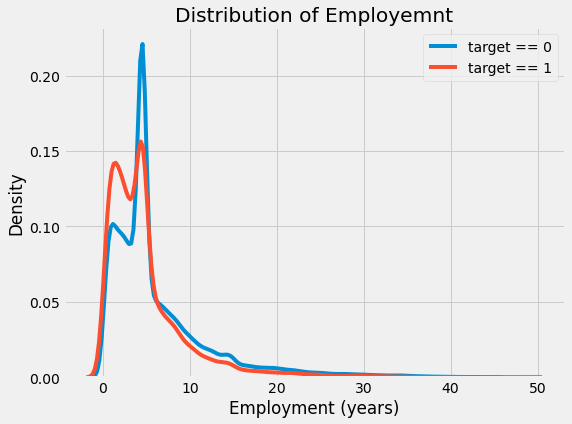

In [86]:
plt.figure(figsize = (8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_EMPLOYED'] / 365, label = 'target == 0')

 # KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_EMPLOYED'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Employment (years)'); plt.ylabel('Density'); plt.title('Distribution of Employemnt');
plt.legend();

The graphs do not show any clear trends.

### Log Transformation
Remove and reduce the skewness, dynamic range of variables, of the original data to follow the bell curve.

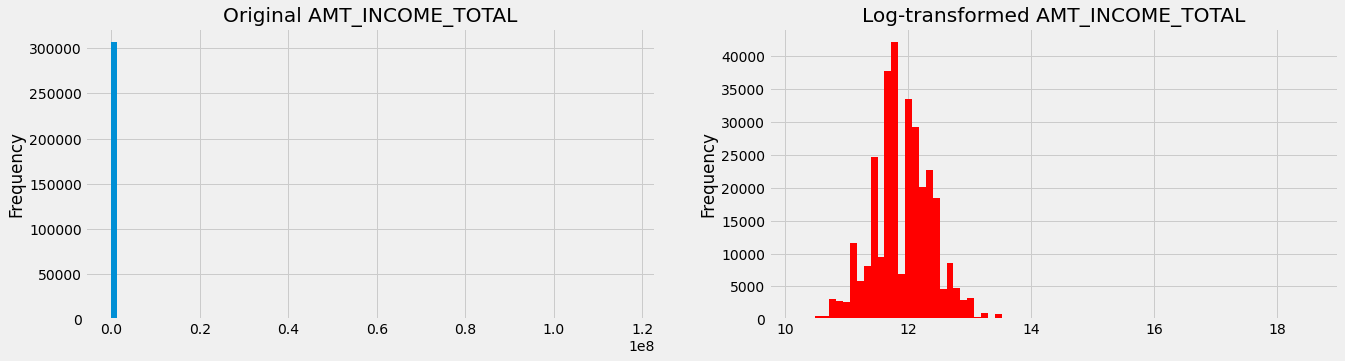

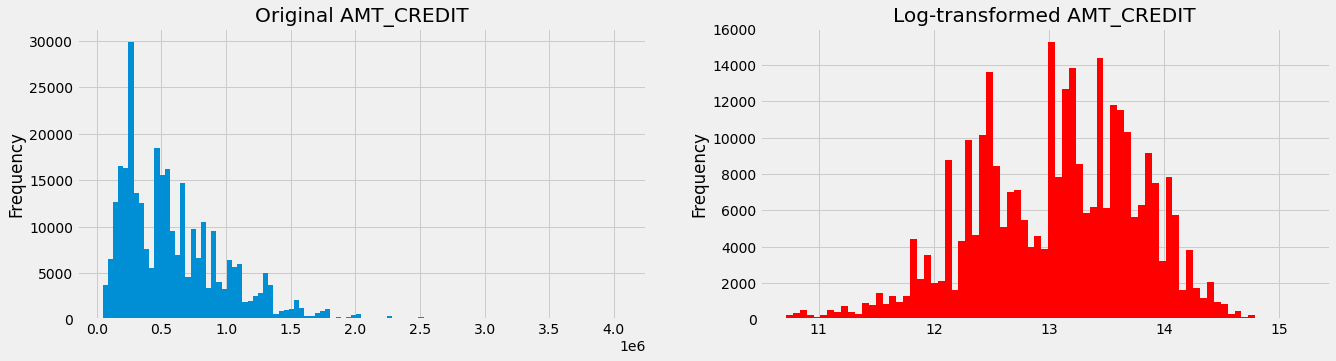

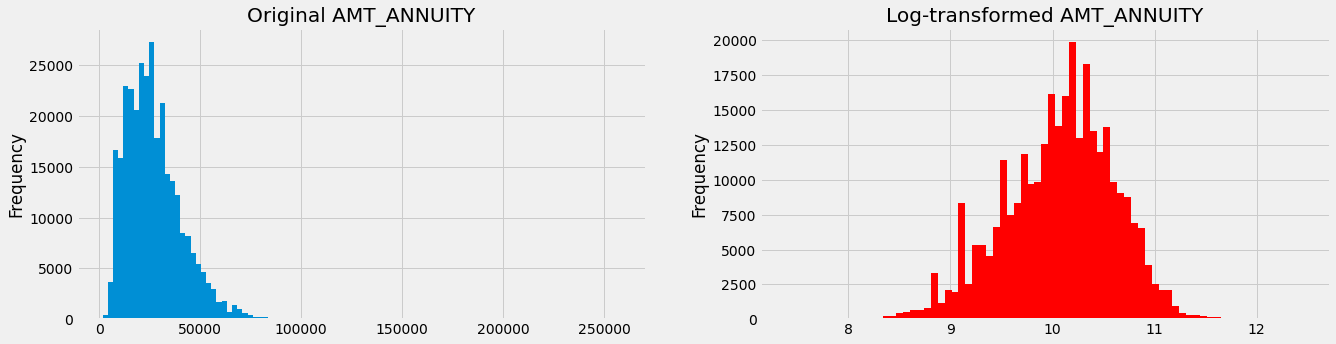

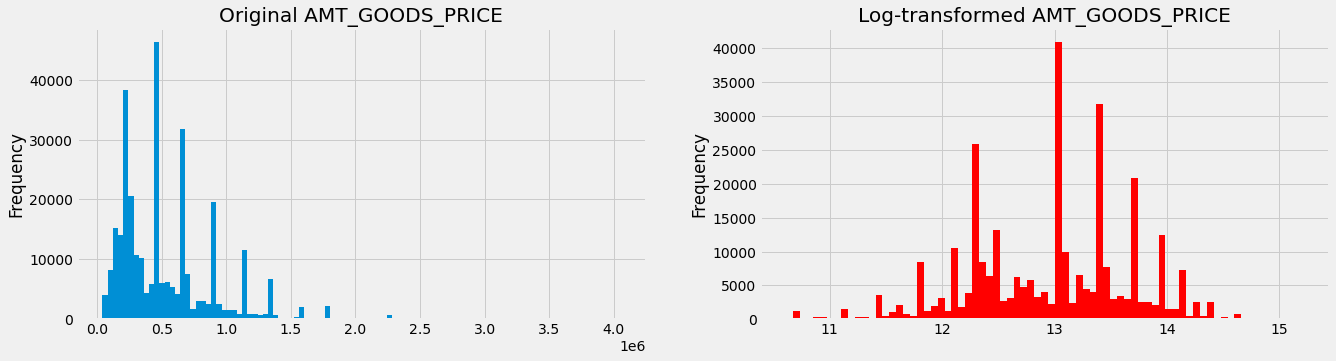

In [87]:
for col in ['AMT_INCOME_TOTAL', 'AMT_CREDIT','AMT_ANNUITY', 'AMT_GOODS_PRICE']:  
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax = ax.flatten()
    
    train[col].plot(kind='hist', bins=100, ax=ax[0])
    ax[0].set_title('Original ' + col)
    
    try:
        train[col].apply(np.log).plot(kind='hist', color='r', bins=75, ax=ax[1])
        train[col] = np.log(train[col])
        ax[1].set_title('Log-transformed ' + col)
    except ValueError:
        print('Feature includes zero(s):' + col)
        
    plt.show()

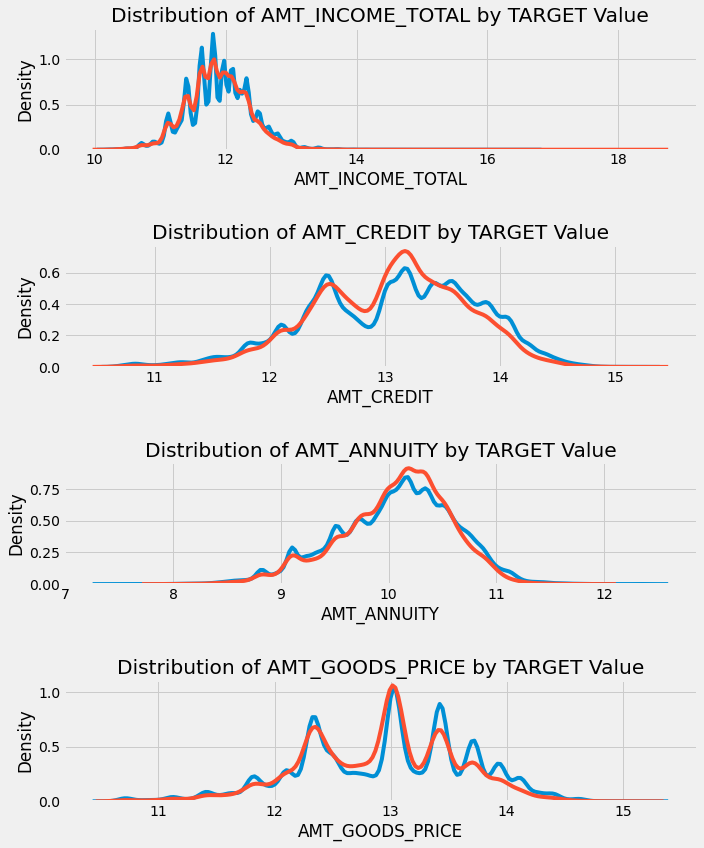

In [88]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['AMT_INCOME_TOTAL', 'AMT_CREDIT','AMT_ANNUITY', 'AMT_GOODS_PRICE']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by TARGET Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

The graphs do not show any clear trends.

### Flag features

In [89]:
train['FLAG_CG_ratio'] = train['AMT_CREDIT'] > train['AMT_GOODS_PRICE']                 # FLAG if borrower borrowed more than the price of the good

### Create new features

In [90]:
# ratio features - create new variables based on existing variables
train['CI_ratio'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']        # credit-to-income ratio
train['AI_ratio'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']       # annuity-to-income ratio
train['GI_ratio'] = train['AMT_GOODS_PRICE'] / train['AMT_INCOME_TOTAL']         # credit to goods price to income ratio - how much was financed?

### Fill missing values

In [91]:
fill_NaN = SimpleImputer(missing_values = np.nan, strategy = 'median', fill_value=None)
imputed_train = pd.DataFrame(fill_NaN.fit_transform(train))
imputed_train.columns = train.columns
imputed_train.index = train.index
missing_values_table(imputed_train)
train = imputed_train

Your selected dataframe has 104 columns.
There are 0 columns that have missing values.


In [92]:
train['YEARS_BIRTH'] = train['DAYS_BIRTH'] / 365
binned = pd.cut(train['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11), labels = False)
train['AGE_band'] = binned

## Split data into train data and test data

In [93]:
train.drop(['TARGET_x', 'TARGET_y'], axis = 1, inplace = True)


In [94]:
y = target.values
X_train, X_valid, y_train, y_valid = train_test_split(train.drop(['SK_ID_CURR', 'TARGET'], axis = 1), y, stratify = y, test_size=0.33, random_state=1)
print('Shape of X_train:',X_train.shape)
print('Shape of y_train:',y_train.shape)
print('Shape of X_valid:',X_valid.shape)
print('Shape of y_valid:',y_valid.shape)

Shape of X_train: (206032, 102)
Shape of y_train: (206032,)
Shape of X_valid: (101479, 102)
Shape of y_valid: (101479,)


## Build models

### Decision Tree Classifier
Decision tree learns simple decision rules inferred from the data features and uses that set of rules to make a tree of decisions. <br>
Advantages: <br>
Simple to understand and to interpret. <br>
Requires little data preparation. <br><br>
Disadvantages: <br>
Overfiiting <br>
No Regression <br>


In [95]:
model_dt = DecisionTreeClassifier(random_state = 1)
model_dt.fit(X_train, y_train)
predictions_dt = model_dt.predict(X_valid)


### Logistic Regression
Logistic regression is a regression algorithm that predicts continuous variables, which means can take infinite number of values. <br>
Advantages: <br>
Handle large dataset <br>
Predict probability <br><br>
Disadvantages: <br>
Limited use case <br>
Cannot handle missing data <br>


In [96]:
model_lr = LogisticRegression(max_iter=1000, solver = 'saga', multi_class='auto')
model_lr.fit(X_train, y_train)
predictions_lr = model_lr.predict(X_valid)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


### Random Forest Classifier
It builds decision trees on different samples and take their majority vote for the classification and average in case of regression. <br>
Advantages: <br>
Easy to interpret <br>
Handles both categorial and continuous data <br>
Handle large dataset <br><br>
Disadvantages: <br>
Complexity <br>
More computational resources are required <br>

In [97]:
model_rf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=1,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_valid)

## Evaluate the model

In [98]:
model = ['Decision Tree Classifier', 'Logistic Regression', 'Random Forest Classifier']
i = 0
for mod in [predictions_dt, predictions_rf]:
    matrix = confusion_matrix(y_valid, mod)
    precision = precision_score(y_valid, mod)
    recall = recall_score(y_valid, mod)
    f1 = f1_score(y_valid, mod)
    
    
    print(model[i] + '\n')
    i = i + 1
    print('Confusion Matrix\n', matrix, '\n')
    print('Precision Score', precision, '\n')
    print('Recall Score', recall, '\n')
    print('F1 Score', f1, '\n')


Decision Tree Classifier

Confusion Matrix
 [[85083  8204]
 [ 6822  1370]] 

Precision Score 0.14309588468769585 

Recall Score 0.167236328125 

F1 Score 0.15422717550377124 

Logistic Regression

Confusion Matrix
 [[63422 29865]
 [ 2839  5353]] 

Precision Score 0.1519961383383497 

Recall Score 0.6534423828125 

F1 Score 0.24662520156645934 



### Accuracy score

In [99]:
# DecisionTreeClassifier
print('DecisionTreeClassifier %.4f' % accuracy_score(y_valid, predictions_dt))

# LogisticRegression
#print('LogisticRegression %.4f' % accuracy_score(y_valid, predictions_lr))

# RandomForestClassifier
print('RandomForestClassifier %.4f' % accuracy_score(y_valid, predictions_rf))

DecisionTreeClassifier 0.8519
RandomForestClassifier 0.6777


### ROC AUC Curve

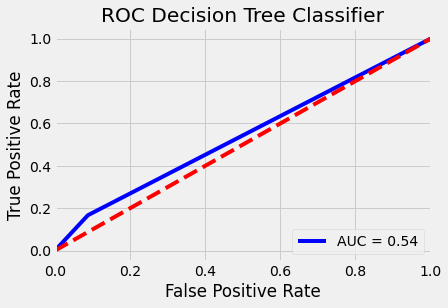

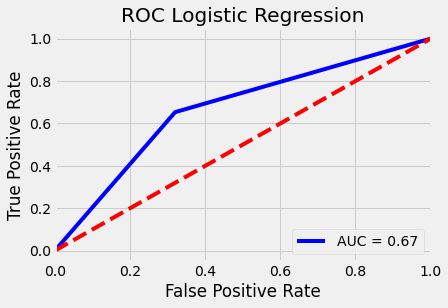

In [100]:
model = ['Decision Tree Classifier', 'Logistic Regression', 'Random Forest Classifier']
i = 0
for pred_model in [predictions_dt, predictions_rf]:
    fpr, tpr, threshold = metrics.roc_curve(y_valid, pred_model)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('ROC ' + model[i])
    i = i + 1
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.xlim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


    

In [101]:
importance = model_dt.feature_importances_
importance

array([0.00120101, 0.00386768, 0.00211223, 0.00335705, 0.00487174,
       0.02054468, 0.0244292 , 0.02971854, 0.01544238, 0.00632704,
       0.00367937, 0.00539319, 0.00950504, 0.00613741, 0.01025605,
       0.0375393 , 0.04135035, 0.03989833, 0.01641065, 0.00060421,
       0.00406319, 0.00388929, 0.00171383, 0.01390549, 0.00681315,
       0.00372747, 0.00305102, 0.01336294, 0.02397141, 0.00140562,
       0.00073169, 0.00177032, 0.00413494, 0.00166659, 0.00236884,
       0.01797713, 0.00696301, 0.01055003, 0.00869885, 0.00569202,
       0.00543992, 0.00109182, 0.00527675, 0.002113  , 0.0032414 ,
       0.00673982, 0.00620021, 0.00644083, 0.00183988, 0.00524991,
       0.00216169, 0.00244526, 0.00708597, 0.0050465 , 0.00572655,
       0.00152713, 0.00320829, 0.00206377, 0.00171231, 0.00791992,
       0.00359442, 0.00175076, 0.01045647, 0.00464125, 0.00161963,
       0.00787021, 0.00375318, 0.00991058, 0.00327179, 0.03074222,
       0.00226195, 0.00144315, 0.00125319, 0.00194784, 0.00125

<AxesSubplot:>

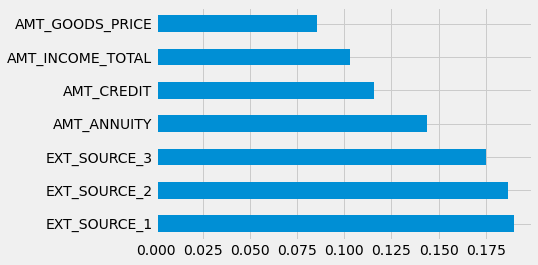

In [102]:
X = pd.read_csv('Desktop/home-credit-default-risk/application_train.csv')
X = X[['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3']].dropna()
y = X.pop('TARGET')

model = RandomForestClassifier()
model.fit(X, y)

(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh'))  

## Conclusion

The Model work with
The three models that use in this machine learning model are Decision Tree Classifier, Logistic Regression, and Random Forest Classifier. 
Since we want to eliminate the cost of not repay the loan, the __Precison Score__, __Accuracy Score__, and __ROC AUC__ will be used to access the performance of the machine learning model. 
As metioned before, all three __EXT_SOURCE__ features show negative correlations with the __TARGET__, indicating that as the value of the __EXT_SOURCE__ increases, the client is more likely to repay the loan. We can also see that __DAYS_BIRTH__ has a high positive correltation with __EXT_SOURCE_1__ indicating that maybe one of the factors in this score is the client age.
Thus, the client age indicates probability of the client loan approval.